## 实验介绍

### 1.实验内容

本实验介绍K均值聚类算法。并通过实验来了解二分k-均值算法。

### 2.实验目标

通过本实验掌握kMeans聚类算法。

### 3.实验知识点

* 聚类

### 4.实验环境

* python 3.6.5  

### 5.预备知识

* 初等数学知识  
* Linux命令基本操作  
* Python编程基础

## 准备工作

点击屏幕右上方的下载实验数据模块，选择下载kmeans_place.tgz到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集压缩包，再使用如下命令解压：

In [1]:
!tar -zxvf kmeans_place.tgz

kmeans_place/
kmeans_place/places.txt
kmeans_place/Portland.png
kmeans_place/testSet.txt


##  【练习】对地图上的点进行聚类
本节，我们将实验《K均值聚类算法》的二分K-均值算法应用于一些真实的数据集上。

有一个文件，该文件存有70个位置的经纬度，如何能最省事的一次走完这70个地方。我们可以设计一个将这些地方进行聚类的最佳策略，这样就可以安排交通工具抵达这些簇的质心，然后步行到每个簇内地址。

最核心的问题还是对这些数据进行聚类分组。

由于我们的数据是这些位置的经纬度，所有我们计算数据点与簇质心的距离时需要使用球面余弦定理来计算。

而代码的实现中，除了我们需要添加一个距离计算函数，其余的都可以重用上节代码。

这里我们新建了一个clusterClubs函数，用来将数据读取，聚类算法和可视化集成到该函数中。

添加如下代码：

划分数据的误差, 未划分数据的误差: 3431.6211509255145, 0.0
最佳划分簇为:  0
最佳簇的长度为:  69
划分数据的误差, 未划分数据的误差: 1230.2420927853307, 1062.0271973570536
划分数据的误差, 未划分数据的误差: 637.0125012771606, 2369.593953568461
最佳划分簇为:  0
最佳簇的长度为:  53
划分数据的误差, 未划分数据的误差: 549.8565864971616, 1461.9522739552924
划分数据的误差, 未划分数据的误差: 515.6100923073567, 1230.2420927853307
划分数据的误差, 未划分数据的误差: 329.2991930704607, 1892.3442135441453
最佳划分簇为:  1
最佳簇的长度为:  16
划分数据的误差, 未划分数据的误差: 471.8115194784125, 915.5351689055955
划分数据的误差, 未划分数据的误差: 53.299046126034725, 1437.9528664974328
划分数据的误差, 未划分数据的误差: 170.75670898476076, 1345.9271084944487
划分数据的误差, 未划分数据的误差: 98.3319961086102, 1538.1414113805854
最佳划分簇为:  0
最佳簇的长度为:  35


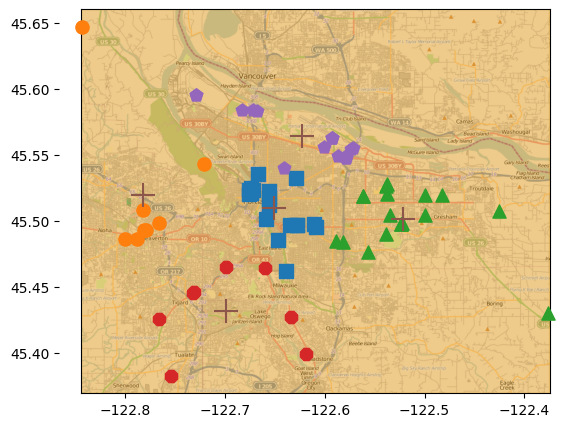

In [39]:

import matplotlib.pyplot as plt


def loadDataSet(fileName):
    """加载数据集

    Args:
        fileName:文件名
    Returns:
        dataMat: 数据列表
    """
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))  #将数据转换为float型数据
        dataMat.append(fltLine)
    return dataMat


def distEclud(vecA, vecB):
    """计算向量欧氏距离

    Args:
        vecA: 向量A
        vecB: 向量B
    Returns:
        dist: 欧氏距离
    """
    #实现使用距离计算公式并返回dist
    dist = np.sqrt(np.sum(np.power(vecA - vecB, 2)))
    # dist = linalg.norm(vecA-vecB)
    return dist


def randCent(dataSet, k):
    """为给定数据集构建一个包含k个随机质心的集合

    Args:
        dataSet: 数据集
        k: 质心个数
    Returns:
        centroids: 质心列表
    """
    n = np.shape(dataSet)[1]  #获得列数
    centroids = np.mat(np.zeros((k, n)))  #创建存储质心的矩阵，初始化为0
    for j in range(n):  #随机质心必须再整个数据集的边界之内
        minJ = min(dataSet[:, j])  #获得数据集中每一个维（每列）的最小值
        rangeJ = float(max(dataSet[:, j]) - minJ)  #获得数据集中每一个维（每列）的取值范围
        centroids[:, j] = np.mat(minJ + rangeJ * np.random.rand(k, 1))  #生成0到1之间的随机数，通过取值范围和最小值，确保随机点在数据的边界之内
    return centroids


def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    """K-均值算法

    Args:
        dataSet: 数据集
        k: 簇个数
        distMeas: 距离计算函数
        createCent: 创建初始质心函数
    Returns:
        centroids: 质心列表
        clusterAssment: 簇分配结果矩阵
    """
    #确定数据集中数据点的总数
    m = np.shape(dataSet)[0]
    #创建矩阵来存储每个点的簇分配结果,第一列记录簇索引值，第二列存储误差
    #误差：当前点到簇质心的距离。后面将使用该误差来评价聚类的效果
    clusterAssment = np.mat(np.zeros((m, 2)))
    #创建初始质心
    centroids = createCent(dataSet, k)
    #标志变量，若为True，则继续迭代
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        #遍历所有数据找到距离每个点最近的质心
        for i in range(m):
            # 初始化最小距离为inf(无穷大) 索引为负
            min_dist = np.inf
            min_index = -1
            #遍历所有质心
            for j in range(k):
                #针对当前数据点, 计算质心与数据点之间的距离
                #注意以行为开头 即 行向量 即对每个数据点计算其到每个类中心点的欧氏距离
                distance = distMeas(centroids[j, :], dataSet[i, :])
                if distance < min_dist:
                    # 每次进行判断是否比上次距离更小 进行存储更小的距离
                    # 直至比较到最后取到最小距离 【不保存所有距离，只保存最小距离】
                    min_dist = distance
                    min_index = j

            # 如果索引即 该数据点的归属类（簇）发生了改变 就继续进行循环
            if clusterAssment[i, 0] != min_index:
                clusterChanged = True
            #将数据点分配到距其最近的簇，并保存距离平方和
            clusterAssment[i, :] = min_index, min_dist ** 2
        #对每一个簇
        for cent in range(k):
            #得到该簇中所有点的值 (找到 当前类质心 下的所有数据点)
            all_data = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]]  # .A 将矩阵转化为数组
            #计算所有点的均值并更新为质心
            centroids[cent, :] = np.mean(all_data, axis=0)
    return centroids, clusterAssment


def drawDataSet(dataMat, centList, myNewAssments, k):
    """绘图

    Args:
        centList: 质心列表
        myNewAssments: 簇列表
        dataMat: 数据集
        k: 簇个数
    Returns:
        null
    """
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]  #绘制矩形
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']  #构建标记形状的列表用于绘制散点图
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(k):  #遍历每个簇
        ptsInCurrCluster = dataMat[np.nonzero(myNewAssments[:, 0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]  #使用索引来选择标记形状
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], ptsInCurrCluster[:, 1].flatten().A[0], marker=markerStyle,
                    s=90)
    ax1.scatter(centList[:, 0].flatten().A[0], centList[:, 1].flatten().A[0], marker='+', s=300)  #使用"+"来标记质心
    plt.show()


def biKmeans(dataSet, k, distMeas=distEclud):
    """函数说明：二分K-均值聚类算法

    Args:
        dataSet: 数据集
        k: 期望簇个数
        distMeas: 距离计算函数
    Returns:
        mat(centList): 质心列表矩阵
        clusterAssment: 聚类结果
    """
    m = np.shape(dataSet)[0]  #得到数据集中样本点的个数
    clusterAssment = np.mat(np.zeros((m, 2)))  #创建存储每个样本点的簇信息
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]  #最初将所有的数据看作一个簇，计算其均值 -> 计算整个数据集的质心
    centList = [centroid0]  #创建一个初始化簇，并使用一个列表来保存所有质心

    for j in range(m):  #遍历所有数据
        clusterAssment[j, 1] = distMeas(np.mat(centroid0), dataSet[j, :]) ** 2  #计算每个样本点与质点的距离（距离的平方）
    # 尝试划分已有的每一个簇,寻找使得SSE降幅最大的那个簇,然后对其进行2-Means聚类划分
    while (len(centList) < k):  #判断是否已经划分到用户指定的簇个数
        #将最小SSE设为无穷大
        lowestSSE = np.inf
        #遍历所有簇
        for i in range(len(centList)):  #尝试划分每一个簇
            #得到该簇所有数据的值
            all_data = dataSet[np.nonzero(clusterAssment[:, 0].A == i)[0], :]  #选择每一个簇中的所有点，作为一个小的数据集
            #在给定的簇上面进行K-均值聚类（k=2）
            centroidMat, splitClustAss = kMeans(all_data, 2, distMeas)  #将该簇用kMeans一分为二，给出质心，分配的质心和误差值
            #计算被划分的数据的误差
            sseSplit = np.sum(splitClustAss[:, 1])
            #计算剩余数据的误差
            sseNoSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:, 0].A != i)[0], 1])
            print(f"划分数据的误差, 未划分数据的误差: {sseSplit}, {sseNoSplit}")
            #如果该划分的误差平方和（SSE）值最小
            if (sseSplit + sseNoSplit) < lowestSSE:
                #将本次划分结果保存
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()  #该簇的划分情况
                lowestSSE = sseSplit + sseNoSplit

        #由于使用二分均值聚类，会得到两个编号分别为0和1的结果簇
        #需要将这些簇编号更新为新加簇的编号
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)  #新加簇的编号
        bestClustAss[np.nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit  #划分簇的编号

        print('最佳划分簇为: ', bestCentToSplit)
        print('最佳簇的长度为: ', len(bestClustAss))
        #更新质心列表
        centList[bestCentToSplit] = bestNewCents[0, :].tolist()[0]
        #将新的质心添加至列表
        centList.append(bestNewCents[1, :].tolist()[0])
        #更新新的簇分配结果
        clusterAssment[np.nonzero(clusterAssment[:, 0].A == bestCentToSplit)[0], :] = bestClustAss
    return np.mat(centList), clusterAssment


def distSLC(vecA, vecB):
    """地球表面两点之间的距离

    Args:
        vecA: 向量A
        vecB: 向量B
    Returns:
        两个向量之间的球面距离
    """
    #使用球面余弦定理计算两点间的距离
    a = np.sin(vecA[0, 1] * np.pi / 180) * np.sin(vecB[0, 1] * np.pi / 180)
    b = np.cos(vecA[0, 1] * np.pi / 180) * np.cos(vecB[0, 1] * np.pi / 180) * np.cos(
        np.pi * (vecB[0, 0] - vecA[0, 0]) / 180)
    return np.arccos(a + b) * 6371.0


def clusterClubs(numClust=5):
    """函数说明：集成文本解析，聚类和画图

    Args:
        numClust: 希望得到的簇个数
    Returns:
        null
    """
    datList = []
    for line in open('kmeans_place/places.txt').readlines():  #类似于loadDataSet函数
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])  #文件第4列和第5列分别对应经度和维度
    datMat = np.mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)  #在数据集上进行二分均值聚类算法
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]  #绘制矩形
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']  #构建标记形状的列表用于绘制散点图
    axprops = dict(xticks=[], yticks=[])
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('kmeans_place/Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):  #遍历每个簇
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:, 0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]  #使用索引来选择标记形状
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], ptsInCurrCluster[:, 1].flatten().A[0], marker=markerStyle,
                    s=90)
    ax1.scatter(myCentroids[:, 0].flatten().A[0], myCentroids[:, 1].flatten().A[0], marker='+', s=300)  #使用"+"来标记质心
    plt.show()


if __name__ == '__main__':
    #对地图上的点进行聚类
    clusterClubs()

从图中我们可以看到，将数据集划分为了5个簇。我们可以尝试输入不同簇数目得到的程序运行结果，思考一下，簇的个数为多少会更好呢？

到此，我们学习了无监督学习中的聚类方法，k-均值聚类算法以及二分K-均值算法和其在真实数据上的应用。但这些算法并非仅有的聚类算法，接下来继续介绍其他的无监督学习算法。

## 【练习】sklearn实现Kmeans聚类算法 
sklearn.cluster库提供很多了聚类方法，本节我们介绍KMeans聚类算法。
![](kmeans_place/1_kmeans_place.png)
主要参数说明：

    n_clusters: 整型，可选，默认为8。最终的簇个数也就是质心个数。
    init: 初始化质心的方法。可选{'k-means++','random'or ndarray}，默认为k-means++。
    k-means++: 用使算法可以快速收敛的方法为k均值聚类选择初始质心
    random: 随机选择
    ndarray：用户设定初始质心列表，形状为(n_clusters,n_features)
    tol: 浮点型，默认值为1e-4,即声明收敛时的相对误差
    random_state: 整型，RandomState实例或None，可选，默认值：None。如果是为整型值，则random_state是随机数生成器使用的种子数; 如果是RandomState实例，则random_state是随机数生成器; 如果没有，随机数生成器所使用的RandomState是np.random。

返回值：

    cluster_centers_:数组型数据，形状为(n_clusters,n_features)质心列表。
    labels_:每个点的标签
    inertia_:浮点型，每个点到其质心的距离平方和

函数:

fit(X[,y])  计算k-means聚类  
fit_predict(X[,y])  计算质心并预测每个数据点的簇标签  
get_params([deep])  得到评价器的参数  
predict(X)  为X数据集中的每个数据预测簇标签  
score(X[,y])    计算该聚类方法的正确率分数


接下来，我们使用sklearn库实现以下kMeans算法,并与我们上一节的k-均值聚类算法相比较。  
在当前工作目录下，添加如下代码：

In [43]:

from sklearn.cluster import KMeans
from numpy import *

X = loadDataSet('kmeans_place/testSet.txt')

#创建KMeans模型，簇个数设置为4个
#调用fit函数进行模型训练
kmeans = KMeans(n_clusters=4, random_state=0, algorithm="elkan").fit(X)
#调用cluster_centers_属性查看最终的聚类中心
centers = kmeans.cluster_centers_

print("sklearn实现质心列表为：", centers)

centroids, _ = kMeans(np.mat(X), 4)
print("python实现质心列表为：", centroids)

sklearn实现质心列表为： [[ 2.6265299   3.10868015]
 [-3.38237045 -2.9473363 ]
 [ 2.80293085 -2.7315146 ]
 [-2.46154315  2.78737555]]
python实现质心列表为： [[ 2.80293085 -2.7315146 ]
 [ 2.6265299   3.10868015]
 [-3.38237045 -2.9473363 ]
 [-2.46154315  2.78737555]]


## 实验总结

本节我们介绍了K均值聚类算法，并实现了二分K-均值聚类算法，您应该能达到以下两个目标：

1. 掌握K均值聚类算法。

2. 学会使用sklearn实现相应算法。

## 参考文献与延伸阅读

### 参考资料:

1.哈林顿，李锐. 机器学习实战 : Machine learning in action[M]. 人民邮电出版社, 2013.  
2.周志华. 机器学习:Machine learning[M]. 清华大学出版社, 2016.

### 延伸阅读

1.李航. 统计学习方法[M]. 清华大学出版社, 2012.